In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
from keras.models import load_model
import streamlit as st
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [2]:
#user input is stock symbol which will be given as input by user in stock.html page.
#same with start and end date input willbe given by user call below all 3.
#give a submit button to user after clicking which the 4 graph should be visible as output on stock.html page.
user_input = 'GOOGL'
start = '2021-06-09'
end = '2022-04-25'
data = data.DataReader(user_input,'yahoo', start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-06-08,2419.520020,2394.780029,2412.010010,2398.439941,1212000,2398.439941
2021-06-09,2412.879883,2396.899902,2411.429932,2407.939941,897100,2407.939941
2021-06-10,2436.000000,2403.780029,2406.919922,2435.129883,1295200,2435.129883
2021-06-11,2441.719971,2418.959961,2440.000000,2430.199951,1097900,2430.199951
2021-06-14,2448.919922,2418.000000,2432.260010,2448.909912,1104900,2448.909912


In [3]:
dff = data.reset_index()
dff.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2021-06-08,2419.520020,2394.780029,2412.010010,2398.439941,1212000,2398.439941
1,2021-06-09,2412.879883,2396.899902,2411.429932,2407.939941,897100,2407.939941
2,2021-06-10,2436.000000,2403.780029,2406.919922,2435.129883,1295200,2435.129883
3,2021-06-11,2441.719971,2418.959961,2440.000000,2430.199951,1097900,2430.199951
4,2021-06-14,2448.919922,2418.000000,2432.260010,2448.909912,1104900,2448.909912


In [4]:
len(dff)

223

In [5]:
opn = dff[['Open']]

Text(0.5, 1.0, 'Opening price')

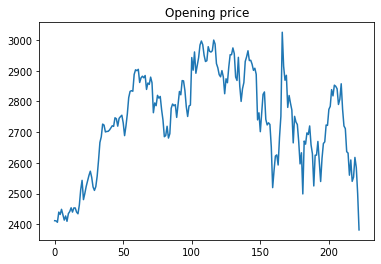

In [6]:
#this graph as output
ds = opn.values
plt.plot(ds)
plt.title('Opening price')


Text(0.5, 1.0, 'Closing price')

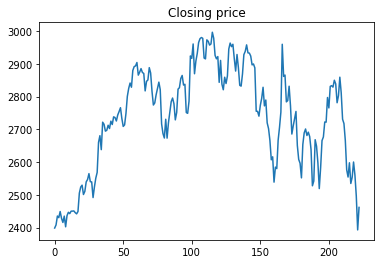

In [7]:

#this graph as output
plt.plot(dff.Close)
plt.title('Closing price')

In [8]:
#Using MinMaxScaler for normalizing data between 0 & 1
scaler = MinMaxScaler(feature_range=(0,1))
ds_scaled = scaler.fit_transform(np.array(ds).reshape(-1,1))

In [9]:
len(ds_scaled), len(ds)

(223, 223)

In [10]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [11]:
train_size,test_size

(156, 67)

In [12]:
#Splitting data between train and test
ds_train = ds_scaled[0:train_size,:]
ds_test = ds_scaled[train_size:len(ds_scaled),:1]

In [13]:
len(ds_train),len(ds_test)

(156, 67)

In [14]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [15]:
#Taking 100 days price as one record for training
time_stamp = 100
x_train, y_train = create_ds(ds_train,time_stamp)
x_test, y_test = create_ds(ds_test,time_stamp)

In [16]:
x_train.shape,y_train.shape

((55, 100), (55,))

In [17]:
x_test.shape, y_test.shape

((0,), (0,))

In [18]:
#Reshaping data to fit into LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

IndexError: tuple index out of range

In [ ]:
x_train , x_test

(array([[[0.00425498],
         [0.00431647],
         [0.00455627],
         ...,
         [0.00829065],
         [0.01125438],
         [0.00962904]],
 
        [[0.00431647],
         [0.00455627],
         [0.00451118],
         ...,
         [0.01125438],
         [0.00962904],
         [0.01182827]],
 
        [[0.00455627],
         [0.00451118],
         [0.00397213],
         ...,
         [0.00962904],
         [0.01182827],
         [0.01193485]],
 
        ...,
 
        [[0.20461818],
         [0.20590943],
         [0.20522077],
         ...,
         [0.23029972],
         [0.2291376 ],
         [0.23029972]],
 
        [[0.20590943],
         [0.20522077],
         [0.20470426],
         ...,
         [0.2291376 ],
         [0.23029972],
         [0.23084492]],
 
        [[0.20522077],
         [0.20470426],
         [0.20810455],
         ...,
         [0.23029972],
         [0.23084492],
         [0.22793244]]]),
 array([[[0.22972584],
         [0.229898  ],
         

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test) ,batch_size=64)

32/32 [==============================] - 13s 245ms/step - loss: 0.0014 - val_loss: 0.0026


In [ ]:
model.save('keras_model.h5')

In [ ]:
#Predicitng on train and test data
x_predicted = model.predict(x_train)
y_predicted = model.predict(x_test)

In [ ]:
#Inverse transform to get actual value
x_predicted =scaler.inverse_transform(x_predicted)
y_predicted = scaler.inverse_transform(y_predicted)

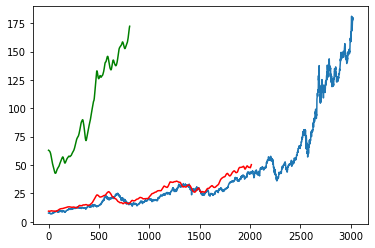

In [ ]:
#Comparing using visuals
plt.plot(scaler.inverse_transform(ds_scaled))
plt.plot(x_predicted,'r')
plt.plot(y_predicted,'g')

In [ ]:
test = np.vstack((x_predicted,y_predicted))

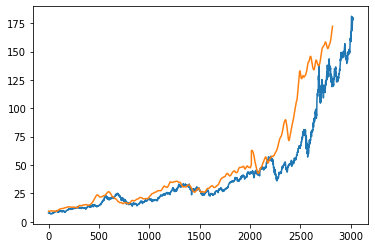

In [ ]:
#this graph as output
#Combining the predited data to create uniform data visualization
plt.plot(scaler.inverse_transform(ds_scaled))
plt.plot(test)

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 637)

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [ ]:
ds_new = ds_scaled.tolist()

In [ ]:
len(ds_new)

3022

In [ ]:
#this graph as output
#Creating final data for plotting
final_graph = scaler.inverse_transform(ds_new).tolist()

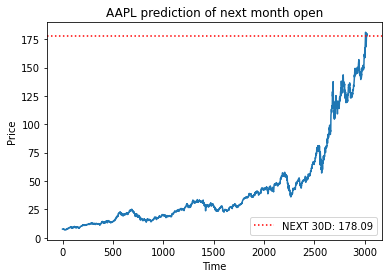

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title(" prediction of next month open of {0}".format('AAPL'))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

